<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/(Not_ready_COCOdata)_DAE_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!wget http://images.cocodataset.org/zips/train2014.zip
!wget http://images.cocodataset.org/zips/val2014.zip
!wget http://images.cocodataset.org/zips/test2014.zip

--2022-02-20 14:31:53--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.227.233
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.227.233|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘/content/drive/MyDrive/Coco2014/train2014.zip’

train2014.zip       100%[===================>]  12.58G  53.4MB/s    in 4m 9s   

2022-02-20 14:36:02 (51.7 MB/s) - ‘/content/drive/MyDrive/Coco2014/train2014.zip’ saved [13510573713/13510573713]



In [ ]:
!mkdir train2014
!mkdir val2014
!mkdir test2014

!unzip train2014.zip -d ./train2014 >> /dev/null
!unzip val2014.zip -d ./val2014 >> /dev/null
!unzip test2014.zip -d ./test2014 >> /dev/null

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr #use of numpy
import math
import cv2
import time

In [ ]:
# Define Loss function
def mse_loss(input, target):
    r = input[:,0:1,:,:] - target[:,0:1,:,:]
    g = (input[:,1:2,:,:] - target[:,1:2,:,:])
    b = input[:,2:3,:,:] - target[:,2:3,:,:]
    
    r = torch.mean(r**2)
    g = torch.mean(g**2)
    b = torch.mean(b**2)
    
    mean = (r + g + b)/3
   
    return mean

In [ ]:
def Get_psnr(input, output, max_val=1.0):
    """
    Remark
    
    input type : tensor
    output type : float
    """
    input = input.cpu().detach().numpy()
    output = output.cpu().detach().numpy()

 #   print(np.max(input)) check. 1임.
 #   print(np.min(input)) ---> 0
 #   print(np.min(output)) ----> 0

    b = input[:,:,0]
    g = input[:,:,1]
    r = input[:,:,2]

    hat_b = output[:,:,0]
    hat_g = output[:,:,1]
    hat_r = output[:,:,2]

    b_img_diff = hat_b - b
    g_img_diff = hat_g - g 
    r_img_diff = hat_r - r
    
    b_mse = np.mean(b_img_diff**2)
    g_mse = np.mean(g_img_diff**2)
    r_mse = np.mean(r_img_diff**2)

    total_mse = r_mse + g_mse + b_mse
    

    if total_mse == 0:
      return 100
    else:
      psnr = 10 * math.log10( (max_val**2)/total_mse)
      return psnr 

In [ ]:
# 훈련 데이터, 검증 데이터, 테스트 데이터순으로 5000개, 10000개, 10000개
tr_dataroot = "./train2014"
valid_dataroot = "./val2014"
tets_dataroot = "./test2014"

tr_dataset = Dataset.ImageFolder(root=tr_dataroot,
                           transform=transforms.Compose([
                               transforms.Resize((128, 128)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

valid_dataset = Dataset.ImageFolder(root=valid_dataroot,
                           transform=transforms.Compose([
                               transforms.Resize((128, 128)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


test_dataset = Dataset.ImageFolder(root=tets_dataroot,
                           transform=transforms.Compose([
                               transforms.Resize((128, 128)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

tr_dataloader = torch.utils.data.DataLoader(tr_dataroot, batch_size=64,
                                         shuffle=True, num_workers=4)

valid_dataloader = torch.utils.data.DataLoader(valid_dataroot, batch_size=64,
                                         shuffle=True, num_workers=4)

test_dataloader = torch.utils.data.DataLoader(tets_dataroot, batch_size=64,
                                         shuffle=True, num_workers=4)



Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch = next(iter(tr_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
batch = next(iter(valid_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
batch = next(iter(test_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
tr_dataset[1][0].shape

torch.Size([3, 32, 32])

In [ ]:
X_train_set = tr_dataset.dataset.data[tr_dataset.indices]
tr_dataset.dataset.targets = torch.tensor(tr_dataset.dataset.targets)

X_val_set = valid_dataset.dataset.data[valid_dataset.indices]
valid_dataset.dataset.targets = torch.tensor(valid_dataset.dataset.targets)

X_test_set = test_dataset.dataset.data[test_dataset.indices]
test_dataset.dataset.targets = torch.tensor(test_dataset.dataset.targets)

'''
dataset을 나누면 tensor 성질이 사라지는건 Mnist와 Cifar10 모두 동일하다.
'''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


'\ndataset을 나누면 tensor 성질이 사라지는건 Mnist와 Cifar10 모두 동일하다.\n'

In [ ]:
X_train_set.shape

(40000, 32, 32, 3)

In [ ]:
X_train_set = torch.tensor(X_train_set)
Y_train_set = tr_dataset.dataset.targets[tr_dataset.indices]

X_val_set = torch.tensor(X_val_set)
Y_val_set =valid_dataset.dataset.targets[valid_dataset.indices]

X_test_set = torch.tensor(X_test_set)
Y_test_set =test_dataset.dataset.targets[test_dataset.indices]

In [ ]:
Y_train_set.shape

torch.Size([40000])

In [ ]:
X_train_set.shape

torch.Size([40000, 32, 32, 3])

In [ ]:
train_set_arr = X_train_set.numpy() #numpy 자료형(ndarray) 변환
val_set_arr = X_val_set.numpy()
test_set_arr = X_test_set.numpy()

In [ ]:
Gaussian_blur_weak_tr_dataset = []
Gaussian_blur_weak_val_dataset = []
Gaussian_blur_weak_test_dataset = []

Gaussian_blur_moderate_tr_dataset = []
Gaussian_blur_moderate_val_dataset = []
Gaussian_blur_moderate_test_dataset = []

Gaussian_blur_strong_tr_dataset = []
Gaussian_blur_strong_val_dataset = []
Gaussian_blur_strong_test_dataset = []


for i in range(len(tr_dataset)):
  Gaussian_blur_weak_tr_dataset.append( [torch.from_numpy(cv2.GaussianBlur(train_set_arr[i], (3,3),0).transpose(2,0,1)).float().div(255.0), Y_train_set[i] ])
#append는 하나의 argument만 수용하므로 대괄호로 묶어줘야 한다.
for i in range(len(valid_dataset)):
  Gaussian_blur_weak_val_dataset.append( [torch.from_numpy(cv2.GaussianBlur(val_set_arr[i],(3,3),0).transpose(2,0,1)).float().div(255.0), Y_val_set[i] ] )
for i in range(len(test_dataset)):
  Gaussian_blur_weak_test_dataset.append( [torch.from_numpy(cv2.GaussianBlur(test_set_arr[i],(3,3),0).transpose(2,0,1)).float().div(255.0), Y_test_set[i] ] )



for i in range(len(tr_dataset)):
  Gaussian_blur_moderate_tr_dataset.append( [torch.from_numpy(cv2.GaussianBlur(train_set_arr[i], (3,3),0).transpose(2,0,1)).float().div(255.0), Y_train_set[i] ])
#append는 하나의 argument만 수용하므로 대괄호로 묶어줘야 한다.
for i in range(len(valid_dataset)):
  Gaussian_blur_moderate_val_dataset.append( [torch.from_numpy(cv2.GaussianBlur(val_set_arr[i],(3,3),0).transpose(2,0,1)).float().div(255.0), Y_val_set[i] ] )
for i in range(len(test_dataset)):
  Gaussian_blur_moderate_test_dataset.append( [torch.from_numpy(cv2.GaussianBlur(test_set_arr[i],(3,3),0).transpose(2,0,1)).float().div(255.0), Y_test_set[i] ] )



for i in range(len(tr_dataset)):
  Gaussian_blur_strong_tr_dataset.append( [torch.from_numpy(cv2.GaussianBlur(train_set_arr[i], (3,3),0).transpose(2,0,1)).float().div(255.0), Y_train_set[i] ])
#append는 하나의 argument만 수용하므로 대괄호로 묶어줘야 한다.
for i in range(len(valid_dataset)):
  Gaussian_blur_strong_val_dataset.append( [torch.from_numpy(cv2.GaussianBlur(val_set_arr[i],(3,3),0).transpose(2,0,1)).float().div(255.0), Y_val_set[i] ] )
for i in range(len(test_dataset)):
  Gaussian_blur_strong_test_dataset.append( [torch.from_numpy(cv2.GaussianBlur(test_set_arr[i],(3,3),0).transpose(2,0,1)).float().div(255.0), Y_test_set[i] ] )


hat_weak_tr_dataloader = DataLoader(Gaussian_blur_weak_tr_dataset, batch_size = 64, num_workers = 4)
hat_weak_val_dataloader = DataLoader(Gaussian_blur_weak_val_dataset, batch_size = 64, num_workers = 4)
hat_weak_test_dataloader = DataLoader(Gaussian_blur_weak_test_dataset, batch_size = 64, num_workers = 4)

hat_moderate_tr_dataloader = DataLoader(Gaussian_blur_moderate_tr_dataset, batch_size = 64, num_workers = 4)
hat_moderate_val_dataloader = DataLoader(Gaussian_blur_moderate_val_dataset, batch_size = 64, num_workers = 4)
hat_moderate_test_dataloader = DataLoader(Gaussian_blur_moderate_test_dataset, batch_size = 64, num_workers = 4)

hat_strong_tr_dataloader = DataLoader(Gaussian_blur_strong_tr_dataset, batch_size = 64, num_workers = 4)
hat_strong_val_dataloader = DataLoader(Gaussian_blur_strong_val_dataset, batch_size = 64, num_workers = 4)
hat_strong_test_dataloader = DataLoader(Gaussian_blur_strong_test_dataset, batch_size = 64, num_workers = 4)

#print(len(hat_tr_dataloader))



In [ ]:
print(torch.from_numpy(cv2.GaussianBlur(train_set_arr[i], (3,3),0).transpose(2,0,1)).shape)

torch.Size([3, 32, 32])


print(torch.from_numpy(cv2.GaussianBlur(train_set_arr[i],(3,3),0).transpose(1,0,2)).float().div(255.0).shape)

Gaussian_blur_weak_tr_arr = np.array([])
y = np.array([])
GS = cv2.GaussianBlur(train_set_arr[1],(3,3),0)
Gaussian_blur_weak_tr_arr = np.append(Gaussian_blur_weak_tr_arr,GS)
print(y.shape)
print(Gaussian_blur_weak_tr_arr.shape)

print(type(GS))

print(Gaussian_blur_weak_tr_arr.shape)

type(Gaussian_blur_weak_tr_arr)

In [ ]:
class DenosingAutoencoder(nn.Module):
  def __init__(self):
    super(DenosingAutoencoder, self).__init__()
    #input = 3 by 128 by 128
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 2, stride = 2, padding=0),
    #1nd 64 by 64 by 32
        nn.ReLU(True),

        nn.Conv2d(in_channels =32, out_channels = 64,  kernel_size = 2, stride = 2, padding=0),
    #2nd 32 by 32 by 64   
        nn.ReLU(True),

        nn.Conv2d(in_channels = 64, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
    #3nd 16 by 16 by 128
        nn.ReLU(True),
    )
    self.decoder = nn.Sequential(
 
        nn.ConvTranspose2d(in_channels = 128, out_channels = 64,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),
    #3nd  32 by 32 by 64  
        nn.ConvTranspose2d(in_channels = 64, out_channels = 32,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),
    #4nd  64 by 64 by 32
        nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size = 2, stride = 2, padding=0),
    #5nd  128 by 128 by 3
        nn.Sigmoid())
  
  def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
#Instantiate the model
model_weak = DenosingAutoencoder()
model_moderate = DenosingAutoencoder()
model_strong = DenosingAutoencoder()



DenosingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


In [ ]:
#Epochs
n_epochs = 5

#Optimizer

optimizer_weak = torch.optim.Adam(model_weak.parameters(), lr=0.001, weight_decay  = 1e-04)

optimizer_moderate = torch.optim.Adam(model_moderate.parameters(), lr=0.001, weight_decay  = 1e-04)

optimizer_strong = torch.optim.Adam(model_strong.parameters(), lr=0.001, weight_decay  = 1e-04)



# lr 0.1에서 1이 최적. 
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)


cuda


DenosingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [ ]:
model_weak.to(device)

Epoch : [1/400] 

0.00040164486204749203
Epoch : [2/400] 

0.0004065783208686575
Epoch : [3/400] 

0.0004147969952721705
Epoch : [4/400] 

0.00042629525251402893
Epoch : [5/400] 

0.00044106521215800214
Training Loss: 0.019566	 validation Loss 0.019505
Class:deer 	 PNSR :15.839589780499798 	 SSIM : 0.6856164696558608
Class:cat 	 PNSR :19.08454417079714 	 SSIM : 0.6748751897796957
Class:deer 	 PNSR :13.003682334912142 	 SSIM : 0.6372424189606258
Class:frog 	 PNSR :9.311864197573293 	 SSIM : 0.6241893563915196
Class:horse 	 PNSR :10.746485086465094 	 SSIM : 0.6335561032427698


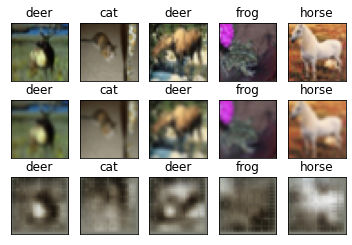

Epoch : [6/400] 

0.00045909675147656585
Epoch : [7/400] 

0.0004803775123886026
Epoch : [8/400] 

0.0005048929099291249
Epoch : [9/400] 

0.0005326261422452204
Epoch : [10/400] 

0.0005635582021113507
Training Loss: 0.016537	 validation Loss 0.016470
Class:deer 	 PNSR :16.44894657617326 	 SSIM : 0.7891287689141592
Class:cat 	 PNSR :20.77968349030099 	 SSIM : 0.779651525907115
Class:deer 	 PNSR :14.193218465652695 	 SSIM : 0.7530277741913013
Class:frog 	 PNSR :9.674530762030408 	 SSIM : 0.6621830705638082
Class:horse 	 PNSR :10.753648950097052 	 SSIM : 0.7025340053547259


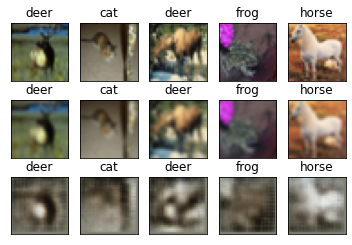

Epoch : [11/400] 

0.0005976678899561293
Epoch : [12/400] 

0.000634931828391647
Epoch : [13/400] 

0.0006753244782353729
Epoch : [14/400] 

0.0007188181560136685
Epoch : [15/400] 

0.0007653830529349183
Training Loss: 0.015217	 validation Loss 0.015101
Class:deer 	 PNSR :17.173135560327 	 SSIM : 0.8218251842720091
Class:cat 	 PNSR :21.156795414878783 	 SSIM : 0.797342752606507
Class:deer 	 PNSR :14.999279426153889 	 SSIM : 0.789983733349628
Class:frog 	 PNSR :9.939173282479256 	 SSIM : 0.7051260169747087
Class:horse 	 PNSR :10.817958305262065 	 SSIM : 0.7595071285568148


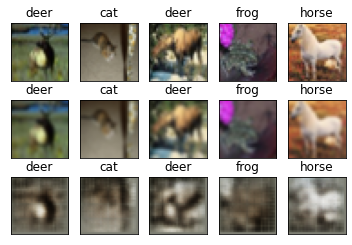

Epoch : [16/400] 

0.0008149872553192515
Epoch : [17/400] 

0.0008675967664708763
Epoch : [18/400] 

0.0009231755299780302
Epoch : [19/400] 

0.0009816854544245704
Epoch : [20/400] 

0.00104308643949628
Training Loss: 0.012721	 validation Loss 0.012461
Class:deer 	 PNSR :17.548146174931777 	 SSIM : 0.8291589889451135
Class:cat 	 PNSR :22.237854723062163 	 SSIM : 0.8130504147253622
Class:deer 	 PNSR :15.365466594385994 	 SSIM : 0.7996584008104209
Class:frog 	 PNSR :10.181315306252081 	 SSIM : 0.7294164069610226
Class:horse 	 PNSR :11.858290299999204 	 SSIM : 0.7439917853072903


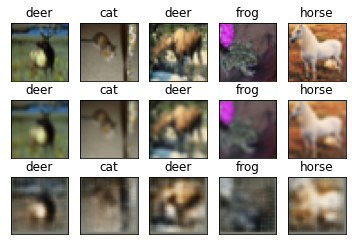

Epoch : [21/400] 

0.0011073364034639831
Epoch : [22/400] 

0.0011743913120246426
Epoch : [23/400] 

0.0012442052084806823
Epoch : [24/400] 

0.0013167302452368242
Epoch : [25/400] 

0.0013919167165928753
Training Loss: 0.011492	 validation Loss 0.011429
Class:deer 	 PNSR :18.072936171133268 	 SSIM : 0.8427775624339445
Class:cat 	 PNSR :23.030849472176342 	 SSIM : 0.8310544691528627
Class:deer 	 PNSR :15.342213553794416 	 SSIM : 0.8089592284796869
Class:frog 	 PNSR :10.316821651645157 	 SSIM : 0.7328713563379363
Class:horse 	 PNSR :12.797243313366975 	 SSIM : 0.7874846926380327


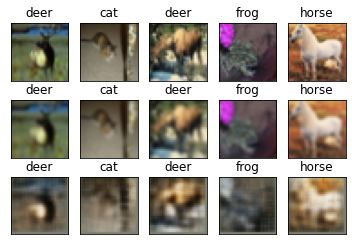

Epoch : [26/400] 

0.0014697130928099985
Epoch : [27/400] 

0.0015500660554270788
Epoch : [28/400] 

0.001632920533803029
Epoch : [29/400] 

0.001718219742859954
Epoch : [30/400] 

0.0018059052220013288
Training Loss: 0.010800	 validation Loss 0.010707
Class:deer 	 PNSR :18.387565206513383 	 SSIM : 0.8550916813022355
Class:cat 	 PNSR :23.030207022462537 	 SSIM : 0.8584052512001735
Class:deer 	 PNSR :15.966823116957585 	 SSIM : 0.8301945872179006
Class:frog 	 PNSR :10.389196986695499 	 SSIM : 0.7506680861510157
Class:horse 	 PNSR :13.902550814932315 	 SSIM : 0.8036990455125336


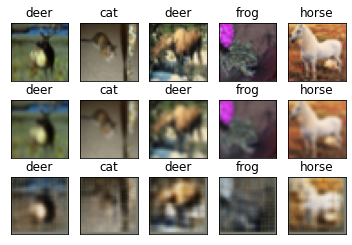

Epoch : [31/400] 

0.0018959168751785053
Epoch : [32/400] 

0.0019881930120780895
Epoch : [33/400] 

0.002082670390401971
Epoch : [34/400] 

0.002179284259211
Epoch : [35/400] 

0.0022779684033026482
Training Loss: 0.010516	 validation Loss 0.011071
Class:deer 	 PNSR :18.350003834826474 	 SSIM : 0.8592997162629583
Class:cat 	 PNSR :22.352499506210826 	 SSIM : 0.8615389532210592
Class:deer 	 PNSR :16.03179895526706 	 SSIM : 0.8362266923258544
Class:frog 	 PNSR :10.388397929050212 	 SSIM : 0.7692000514656175
Class:horse 	 PNSR :13.896289536397468 	 SSIM : 0.8129427653090305


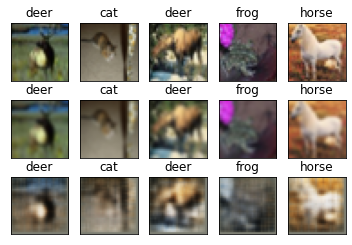

Epoch : [36/400] 

0.0023786551885922073
Epoch : [37/400] 

0.002481275608466423
Epoch : [38/400] 

0.002585759331077817
Epoch : [39/400] 

0.002692034747547263
Epoch : [40/400] 

0.002800029021041788
Training Loss: 0.010408	 validation Loss 0.010477
Class:deer 	 PNSR :18.584973207719354 	 SSIM : 0.8632512948307863
Class:cat 	 PNSR :22.974433899170926 	 SSIM : 0.8640024657598807
Class:deer 	 PNSR :16.44684831343654 	 SSIM : 0.8492841675700659
Class:frog 	 PNSR :10.473006424841156 	 SSIM : 0.7720744501798856
Class:horse 	 PNSR :14.243636483886352 	 SSIM : 0.8202204878271919


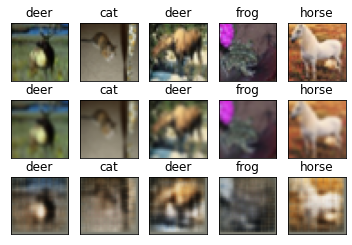

Epoch : [41/400] 

0.0029096681366939684
Epoch : [42/400] 

0.003020876952328698
Epoch : [43/400] 

0.0031335792499625655
Epoch : [44/400] 

0.0032476977880405546
Epoch : [45/400] 

0.0033631543543742462
Training Loss: 0.010380	 validation Loss 0.010294
Class:deer 	 PNSR :18.34173797798214 	 SSIM : 0.8580629642424258
Class:cat 	 PNSR :23.155697867286293 	 SSIM : 0.8685277674950819
Class:deer 	 PNSR :16.547477803312766 	 SSIM : 0.8531526034426381
Class:frog 	 PNSR :10.547099168670469 	 SSIM : 0.7637772782406982
Class:horse 	 PNSR :14.365164254576158 	 SSIM : 0.8304029207189512


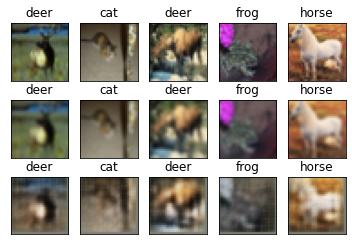

Epoch : [46/400] 

0.003479869819745269
Epoch : [47/400] 

0.0035977641921372287
Epoch : [48/400] 

0.003716756671558975
Epoch : [49/400] 

0.0038367657054216185
Epoch : [50/400] 

0.003957709044431341
Training Loss: 0.010378	 validation Loss 0.010386
Class:deer 	 PNSR :18.208245749331464 	 SSIM : 0.853077064331171
Class:cat 	 PNSR :22.757738269144085 	 SSIM : 0.8608310965098417
Class:deer 	 PNSR :16.3703979273216 	 SSIM : 0.855291547816177
Class:frog 	 PNSR :10.572512123004854 	 SSIM : 0.757249776502548
Class:horse 	 PNSR :14.361199204689681 	 SSIM : 0.8312883478657183


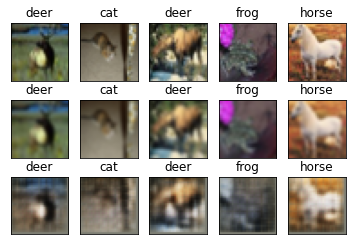

Epoch : [51/400] 

0.0040795037989597134
Epoch : [52/400] 

0.004202066495852857
Epoch : [53/400] 

0.0043253131356405395
Epoch : [54/400] 

0.004449159250105984
Epoch : [55/400] 

0.004573519960176933
Training Loss: 0.010421	 validation Loss 0.010249
Class:deer 	 PNSR :18.161768996687705 	 SSIM : 0.8554831653723264
Class:cat 	 PNSR :23.00038249926065 	 SSIM : 0.8648549994041349
Class:deer 	 PNSR :16.261676601234573 	 SSIM : 0.8574004971635332
Class:frog 	 PNSR :10.613547695137393 	 SSIM : 0.7635829298150871
Class:horse 	 PNSR :14.306692394836851 	 SSIM : 0.8324629573353697


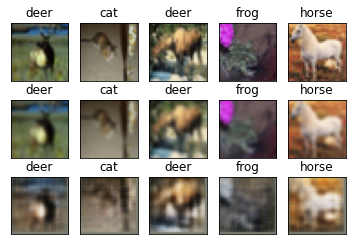

Epoch : [56/400] 

0.004698310034098305
Epoch : [57/400] 

0.004823443945846561
Epoch : [58/400] 

0.004948835933745747
Epoch : [59/400] 

0.005074400059245046
Epoch : [60/400] 

0.005200050265817561
Training Loss: 0.010457	 validation Loss 0.011259
Class:deer 	 PNSR :17.732641987458415 	 SSIM : 0.8534952907435184
Class:cat 	 PNSR :21.487877944680708 	 SSIM : 0.8587506381799624
Class:deer 	 PNSR :15.841834302846669 	 SSIM : 0.852909610708433
Class:frog 	 PNSR :10.5580768837381 	 SSIM : 0.7661901998307279
Class:horse 	 PNSR :14.128548708368633 	 SSIM : 0.8252308466585907


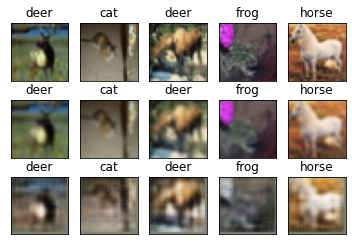

Epoch : [61/400] 

0.005325700437939937
Epoch : [62/400] 

0.005451264460112428
Epoch : [63/400] 

0.005576656275878952
Epoch : [64/400] 

0.005701789946806666
Epoch : [65/400] 

0.005826579711384665
Training Loss: 0.010526	 validation Loss 0.010359
Class:deer 	 PNSR :18.027793260000166 	 SSIM : 0.8600881565215336
Class:cat 	 PNSR :22.830677223970852 	 SSIM : 0.870550455560446
Class:deer 	 PNSR :16.25455287982627 	 SSIM : 0.8595159384788124
Class:frog 	 PNSR :10.620254296272723 	 SSIM : 0.7748892777326836
Class:horse 	 PNSR :14.14542340510957 	 SSIM : 0.8349801327625844


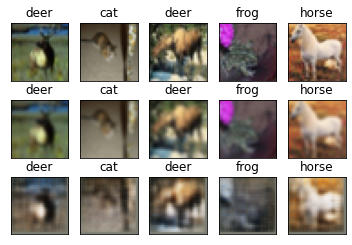

Epoch : [66/400] 

0.005950940043801418
Epoch : [67/400] 

0.006074785712560676
Epoch : [68/400] 

0.0061980318388956505
Epoch : [69/400] 

0.006320593954941464
Epoch : [70/400] 

0.006442388061625971
Training Loss: 0.010630	 validation Loss 0.010496
Class:deer 	 PNSR :17.982542826211937 	 SSIM : 0.8413218856674335
Class:cat 	 PNSR :22.745622420218844 	 SSIM : 0.8394982363418477
Class:deer 	 PNSR :16.055561025696825 	 SSIM : 0.8476625009379228
Class:frog 	 PNSR :10.64180201276826 	 SSIM : 0.7554899524059625
Class:horse 	 PNSR :14.048223353559482 	 SSIM : 0.8163914526533899


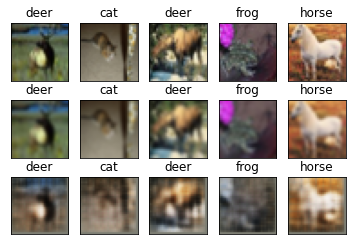

Epoch : [71/400] 

0.006563330686239299
Epoch : [72/400] 

0.006683338939642638
Epoch : [73/400] 

0.006802330573077064
Epoch : [74/400] 

0.006920224034533493
Epoch : [75/400] 

0.0070369385246450925
Training Loss: 0.010755	 validation Loss 0.011843
Class:deer 	 PNSR :17.79427759336915 	 SSIM : 0.8271433383227905
Class:cat 	 PNSR :21.184100367284707 	 SSIM : 0.8315851071571858
Class:deer 	 PNSR :15.29818578433056 	 SSIM : 0.8416503596266088
Class:frog 	 PNSR :10.526535242252457 	 SSIM : 0.7534552953567507
Class:horse 	 PNSR :13.82092249118504 	 SSIM : 0.8092389472365745


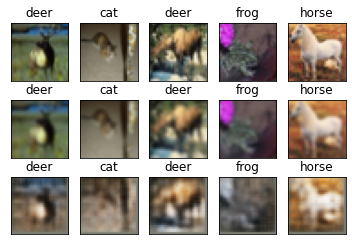

Epoch : [76/400] 

0.007152394052063874
Epoch : [77/400] 

0.0072665114882834924
Epoch : [78/400] 

0.0073792126218706995
Epoch : [79/400] 

0.007490420212068267
Epoch : [80/400] 

0.007600058041732652
Training Loss: 0.010896	 validation Loss 0.011170
Class:deer 	 PNSR :18.27224397924487 	 SSIM : 0.8287366765004777
Class:cat 	 PNSR :22.299041629313543 	 SSIM : 0.8314947014359135
Class:deer 	 PNSR :15.575473986885111 	 SSIM : 0.8390181386362537
Class:frog 	 PNSR :10.580517180934494 	 SSIM : 0.7367633550646433
Class:horse 	 PNSR :14.166507841892958 	 SSIM : 0.8132401932455998


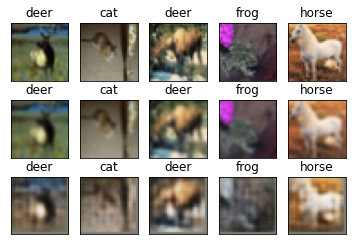

Epoch : [81/400] 

0.007708050969570107
Epoch : [82/400] 

0.007814324981635468
Epoch : [83/400] 

0.007918807242058285
Epoch : [84/400] 

0.008021426142961556
Epoch : [85/400] 

0.008122111353538844
Training Loss: 0.011014	 validation Loss 0.010497
Class:deer 	 PNSR :18.11671621756164 	 SSIM : 0.8495971539312315
Class:cat 	 PNSR :22.261917615740426 	 SSIM : 0.8612790431930244
Class:deer 	 PNSR :15.55736187484193 	 SSIM : 0.8505308969752918
Class:frog 	 PNSR :10.550965561900975 	 SSIM : 0.7640305350041577
Class:horse 	 PNSR :14.064322946478963 	 SSIM : 0.8210257611782548


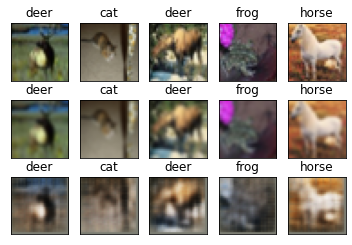

Epoch : [86/400] 

0.008220793868256138
Epoch : [87/400] 

0.008317406054145432
Epoch : [88/400] 

0.008411881697157605
Epoch : [89/400] 

0.008504156047542826
Epoch : [90/400] 

0.00859416586422738
Training Loss: 0.011073	 validation Loss 0.011346
Class:deer 	 PNSR :18.17651804532788 	 SSIM : 0.8397734048208605
Class:cat 	 PNSR :22.12952925170009 	 SSIM : 0.8391654567771876
Class:deer 	 PNSR :15.385011990977226 	 SSIM : 0.8435033388666003
Class:frog 	 PNSR :10.484559305943764 	 SSIM : 0.7423749925747831
Class:horse 	 PNSR :14.248264900769502 	 SSIM : 0.8202274854839917


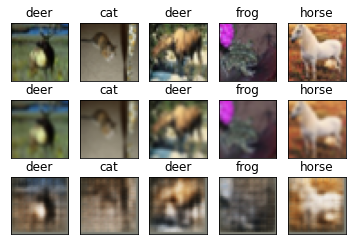

Epoch : [91/400] 

0.00868184945815653
Epoch : [92/400] 

0.008767146734573678
Epoch : [93/400] 

0.00884999923420685
Epoch : [94/400] 

0.008930350173334305
Epoch : [95/400] 

0.00900814448270177
Training Loss: 0.011394	 validation Loss 0.010853
Class:deer 	 PNSR :18.47093655048395 	 SSIM : 0.8481370976621315
Class:cat 	 PNSR :22.472456529691904 	 SSIM : 0.8511452467391342
Class:deer 	 PNSR :15.69640075617924 	 SSIM : 0.8441630325039102
Class:frog 	 PNSR :10.449193255878109 	 SSIM : 0.7650024862185353
Class:horse 	 PNSR :13.915387066352697 	 SSIM : 0.8202121098203188


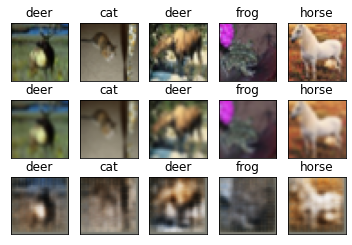

Epoch : [96/400] 

0.009083328845264664
Epoch : [97/400] 

0.009155851732729427
Epoch : [98/400] 

0.00922566344086891
Epoch : [99/400] 

0.009292716123587614
Epoch : [100/400] 

0.009356963825713462
Training Loss: 0.011463	 validation Loss 0.011204
Class:deer 	 PNSR :17.683678143612006 	 SSIM : 0.8308547572858304
Class:cat 	 PNSR :22.031492702278417 	 SSIM : 0.8260425075770219
Class:deer 	 PNSR :15.349783456481575 	 SSIM : 0.8336524237146762
Class:frog 	 PNSR :10.469070360380597 	 SSIM : 0.7431101100855599
Class:horse 	 PNSR :13.927547904086381 	 SSIM : 0.8161787692965811


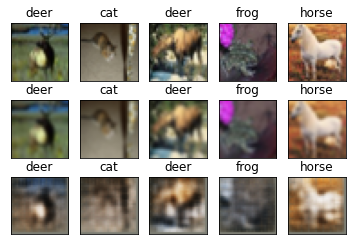

Epoch : [101/400] 

0.009418362514493595
Epoch : [102/400] 

0.00947687010977262
Epoch : [103/400] 

0.009532446512832634
Epoch : [104/400] 

0.009585053633875252
Epoch : [105/400] 

0.009634655418126794
Training Loss: 0.011566	 validation Loss 0.011788
Class:deer 	 PNSR :17.93598982342113 	 SSIM : 0.8202380595667332
Class:cat 	 PNSR :22.554191107589986 	 SSIM : 0.8113940428126275
Class:deer 	 PNSR :15.530869009455358 	 SSIM : 0.81792619423803
Class:frog 	 PNSR :10.555727091151601 	 SSIM : 0.7371505190317281
Class:horse 	 PNSR :14.07687392709249 	 SSIM : 0.7990635552371822


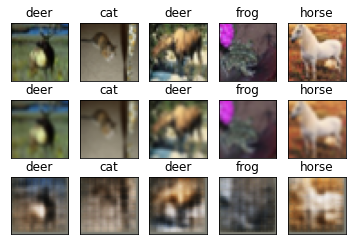

Epoch : [106/400] 

0.009681217870548757
Epoch : [107/400] 

0.009724709079136631
Epoch : [108/400] 

0.00976509923679108
Epoch : [109/400] 

0.009802360661746513
Epoch : [110/400] 

0.009836467816543036
Training Loss: 0.011604	 validation Loss 0.011696
Class:deer 	 PNSR :17.56163316283275 	 SSIM : 0.8282980401067555
Class:cat 	 PNSR :21.699708763588287 	 SSIM : 0.8256397973703692
Class:deer 	 PNSR :15.693992422006742 	 SSIM : 0.826232261630868
Class:frog 	 PNSR :10.487602842501607 	 SSIM : 0.7392486150026111
Class:horse 	 PNSR :13.922792861974427 	 SSIM : 0.804276114365818


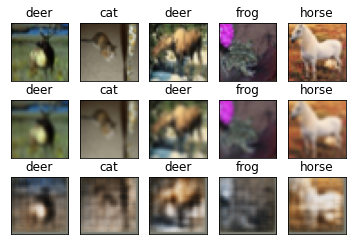

Epoch : [111/400] 

0.009867397325528788
Epoch : [112/400] 

0.009895127990880648
Epoch : [113/400] 

0.009919640807132375
Epoch : [114/400] 

0.009940918974200163
Epoch : [115/400] 

0.009958947908896742
Training Loss: 0.011559	 validation Loss 0.013202
Class:deer 	 PNSR :17.488328395665114 	 SSIM : 0.8230513644562549
Class:cat 	 PNSR :20.79363612149131 	 SSIM : 0.8230966553255433
Class:deer 	 PNSR :14.98613303470291 	 SSIM : 0.825779433692127
Class:frog 	 PNSR :10.387386401305639 	 SSIM : 0.7417698414632956
Class:horse 	 PNSR :13.634599927591102 	 SSIM : 0.8023225686657623


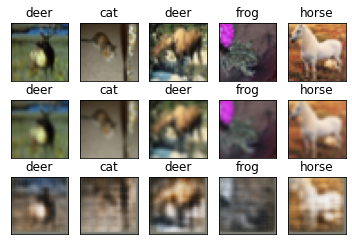

Epoch : [116/400] 

0.009973715254926095
Epoch : [117/400] 

0.009985210891351962
Epoch : [118/400] 

0.009993426939534313
Epoch : [119/400] 

0.009998357768529052
Epoch : [120/400] 

0.00999999999979858
Training Loss: 0.011984	 validation Loss 0.011853
Class:deer 	 PNSR :17.585839106568216 	 SSIM : 0.8364500953061124
Class:cat 	 PNSR :21.972785136445196 	 SSIM : 0.8341664923974039
Class:deer 	 PNSR :15.598176097256067 	 SSIM : 0.8213136925598391
Class:frog 	 PNSR :10.324976389822355 	 SSIM : 0.7469911480429657
Class:horse 	 PNSR :13.32503373832266 	 SSIM : 0.7969221906402376


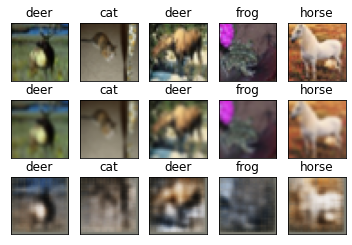

Epoch : [121/400] 

0.009999684781292295
Epoch : [122/400] 

0.009998740172532522
Epoch : [123/400] 

0.009997166292432745
Epoch : [124/400] 

0.009994963339123203
Epoch : [125/400] 

0.009992131589925958
Training Loss: 0.012639	 validation Loss 0.012661
Class:deer 	 PNSR :18.209846310579433 	 SSIM : 0.8160765755131013
Class:cat 	 PNSR :23.193752772276657 	 SSIM : 0.8135343878636697
Class:deer 	 PNSR :15.355030788053465 	 SSIM : 0.8047948713777421
Class:frog 	 PNSR :10.127474937949202 	 SSIM : 0.71476143295635
Class:horse 	 PNSR :13.601296167528126 	 SSIM : 0.7747929979734436


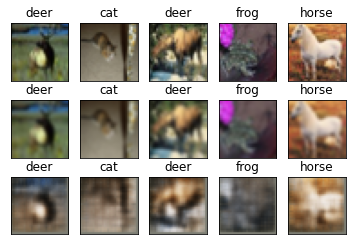

Epoch : [126/400] 

0.00998867140131998
Epoch : [127/400] 

0.00998458320889627
Epoch : [128/400] 

0.009979867527303022
Epoch : [129/400] 

0.009974524950180847
Epoch : [130/400] 

0.009968556150088025
Training Loss: 0.012922	 validation Loss 0.012827
Class:deer 	 PNSR :18.090143458033623 	 SSIM : 0.8017520553542923
Class:cat 	 PNSR :22.985836466250365 	 SSIM : 0.7951166128018506
Class:deer 	 PNSR :14.960389942204301 	 SSIM : 0.7874053984713042
Class:frog 	 PNSR :10.164684504761938 	 SSIM : 0.7175712631808132
Class:horse 	 PNSR :13.523999191954847 	 SSIM : 0.7639214525004651


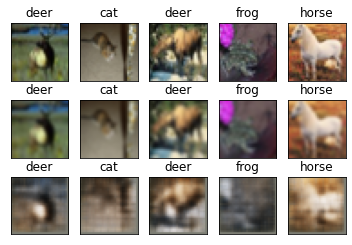

Epoch : [131/400] 

0.009961961878415856
Epoch : [132/400] 

0.009954742965294057
Epoch : [133/400] 

0.009946900319486267
Epoch : [134/400] 

0.009938434928275647
Epoch : [135/400] 

0.009929347857340584
Training Loss: 0.012842	 validation Loss 0.017303
Class:deer 	 PNSR :16.488621402827025 	 SSIM : 0.7970618408988459
Class:cat 	 PNSR :18.06190147288591 	 SSIM : 0.7942627244616834
Class:deer 	 PNSR :13.8692891571435 	 SSIM : 0.7744771813878654
Class:frog 	 PNSR :9.853558406436923 	 SSIM : 0.7058695979084973
Class:horse 	 PNSR :12.035245995070326 	 SSIM : 0.7382679634238499


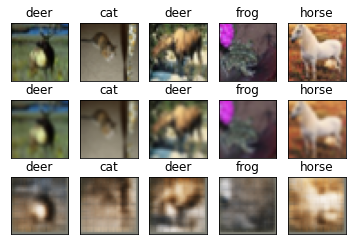

Epoch : [136/400] 

0.009919640250620549
Epoch : [137/400] 

0.009909313330172085
Epoch : [138/400] 

0.009898368396014965
Epoch : [139/400] 

0.00988680682596854
Epoch : [140/400] 

0.009874630075478289
Training Loss: 0.015859	 validation Loss 0.015681
Class:deer 	 PNSR :16.88230658779718 	 SSIM : 0.8030720215557388
Class:cat 	 PNSR :20.38205085771885 	 SSIM : 0.8015883151480478
Class:deer 	 PNSR :14.56631576840711 	 SSIM : 0.7771518287234906
Class:frog 	 PNSR :10.05978845305086 	 SSIM : 0.7178495134245075
Class:horse 	 PNSR :10.601991924889454 	 SSIM : 0.7600970213382251


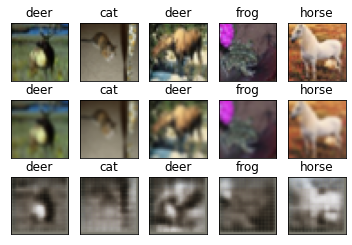

Epoch : [141/400] 

0.009861839677432599
Epoch : [142/400] 

0.009848437241969793
Epoch : [143/400] 

0.009834424456275435
Epoch : [144/400] 

0.009819803084369942
Epoch : [145/400] 

0.00980457496688651
Training Loss: 0.016141	 validation Loss 0.016046
Class:deer 	 PNSR :16.35805838486568 	 SSIM : 0.7821525322407462
Class:cat 	 PNSR :19.95089000474801 	 SSIM : 0.7966981998125527
Class:deer 	 PNSR :14.410632221752941 	 SSIM : 0.7643442608278269
Class:frog 	 PNSR :10.037545305290456 	 SSIM : 0.7052125406626287
Class:horse 	 PNSR :10.51321305059213 	 SSIM : 0.7438029618978282


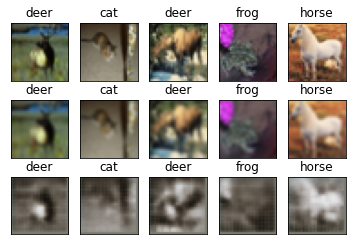

Epoch : [146/400] 

0.009788742020839406
Epoch : [147/400] 

0.009772306239382647
Epoch : [148/400] 

0.009755269691559078
Epoch : [149/400] 

0.009737634522039918
Epoch : [150/400] 

0.009719402950854768
Training Loss: 0.016016	 validation Loss 0.015918
Class:deer 	 PNSR :16.568291852351567 	 SSIM : 0.7791489421004787
Class:cat 	 PNSR :20.45116002252113 	 SSIM : 0.7927916864330635
Class:deer 	 PNSR :14.564127281017644 	 SSIM : 0.7646912082954055
Class:frog 	 PNSR :10.112372690727259 	 SSIM : 0.7101970878161565
Class:horse 	 PNSR :10.580554166136555 	 SSIM : 0.7448905425929095


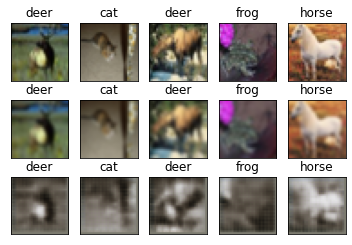

Epoch : [151/400] 

0.009700577273112144
Epoch : [152/400] 

0.009681159858710547
Epoch : [153/400] 

0.009661153152040136
Epoch : [154/400] 

0.009640559671675
Epoch : [155/400] 

0.009619382010056115
Training Loss: 0.015998	 validation Loss 0.015966
Class:deer 	 PNSR :16.40529288686471 	 SSIM : 0.7897768375784819
Class:cat 	 PNSR :19.87451056045244 	 SSIM : 0.8217168203603409
Class:deer 	 PNSR :14.443862890552314 	 SSIM : 0.7676911278685723
Class:frog 	 PNSR :10.028710594603044 	 SSIM : 0.7172090164336632
Class:horse 	 PNSR :10.483392036922783 	 SSIM : 0.7462133449441231


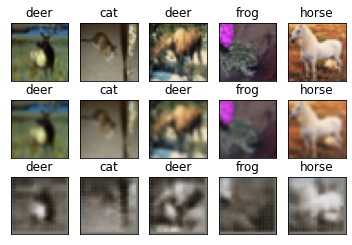

Epoch : [156/400] 

0.009597622833164973
Epoch : [157/400] 

0.009575284880188
Epoch : [158/400] 

0.0095523709631717
Epoch : [159/400] 

0.009528883966668672
Epoch : [160/400] 

0.00950482684737448
Training Loss: 0.016630	 validation Loss 0.016230
Class:deer 	 PNSR :16.151061799753958 	 SSIM : 0.7833976149128432
Class:cat 	 PNSR :20.023826227449106 	 SSIM : 0.8119174853890421
Class:deer 	 PNSR :14.064658697946584 	 SSIM : 0.7595395633322353
Class:frog 	 PNSR :9.982039581490307 	 SSIM : 0.7028293335669641
Class:horse 	 PNSR :10.511819986672732 	 SSIM : 0.7228633935874645


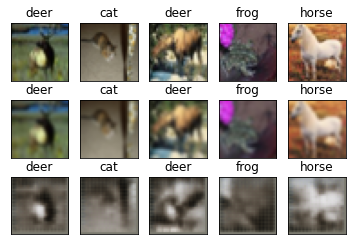

Epoch : [161/400] 

0.009480202633755446
Epoch : [162/400] 

0.009455014425667407
Epoch : [163/400] 

0.009429265393965483
Epoch : [164/400] 

0.009402958780104912
Epoch : [165/400] 

0.009376097895732993
Training Loss: 0.016407	 validation Loss 0.016463
Class:deer 	 PNSR :16.22312404509462 	 SSIM : 0.7848919412172831
Class:cat 	 PNSR :19.976509129214627 	 SSIM : 0.8069904133300413
Class:deer 	 PNSR :14.035923192260736 	 SSIM : 0.7586576563750128
Class:frog 	 PNSR :9.875411763164239 	 SSIM : 0.7116961602952898
Class:horse 	 PNSR :10.691960970712195 	 SSIM : 0.7275070295891756


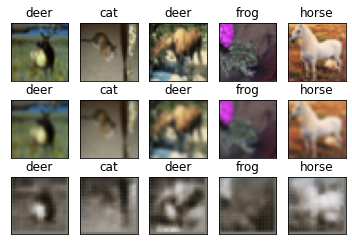

Epoch : [166/400] 

0.009348686122272193
Epoch : [167/400] 

0.009320726910494473
Epoch : [168/400] 

0.009292223780086884
Epoch : [169/400] 

0.009263180319208485
Epoch : [170/400] 

0.009233600184038642
Training Loss: 0.016228	 validation Loss 0.016322
Class:deer 	 PNSR :15.930226827534009 	 SSIM : 0.79217002354127
Class:cat 	 PNSR :19.476178216236317 	 SSIM : 0.8015073589338316
Class:deer 	 PNSR :14.006323167784629 	 SSIM : 0.761443158287468
Class:frog 	 PNSR :9.90977491414702 	 SSIM : 0.7074221962678702
Class:horse 	 PNSR :10.63514971941417 	 SSIM : 0.73278397677182


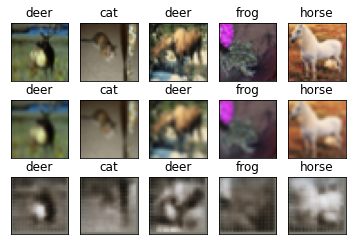

Epoch : [171/400] 

0.00920348709831676
Epoch : [172/400] 

0.009172844852873525
Epoch : [173/400] 

0.009141677305153677
Epoch : [174/400] 

0.009109988378730421
Epoch : [175/400] 

0.009077782062811493
Training Loss: 0.016261	 validation Loss 0.016306
Class:deer 	 PNSR :15.937071471644874 	 SSIM : 0.795322725013893
Class:cat 	 PNSR :19.708517667193966 	 SSIM : 0.7966948738653575
Class:deer 	 PNSR :14.043362319654902 	 SSIM : 0.7588549184792281
Class:frog 	 PNSR :9.92364206929342 	 SSIM : 0.7072665923945598
Class:horse 	 PNSR :10.654352815195157 	 SSIM : 0.73649410346292


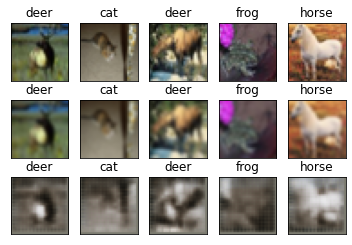

Epoch : [176/400] 

0.00904506241173698
Epoch : [177/400] 

0.009011833544468932
Epoch : [178/400] 

0.008978099644072833
Epoch : [179/400] 

0.00894386495719102
Epoch : [180/400] 

0.00890913379350808
Training Loss: 0.016659	 validation Loss 0.016394
Class:deer 	 PNSR :16.120279392953538 	 SSIM : 0.7887855278882294
Class:cat 	 PNSR :20.04499733175845 	 SSIM : 0.8083570291299648
Class:deer 	 PNSR :14.018292751257096 	 SSIM : 0.7486238219601845
Class:frog 	 PNSR :9.943238275796507 	 SSIM : 0.699556710134884
Class:horse 	 PNSR :10.669522138534319 	 SSIM : 0.7274220899409786


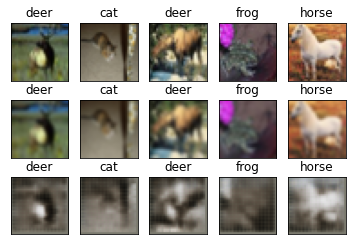

Epoch : [181/400] 

0.008873910525208323
Epoch : [182/400] 

0.008838199586425384
Epoch : [183/400] 

0.00880200547268402
Epoch : [184/400] 

0.008765332740334196
Epoch : [185/400] 

0.00872818600597748
Training Loss: 0.016422	 validation Loss 0.016472
Class:deer 	 PNSR :16.01794508339986 	 SSIM : 0.7924224330173216
Class:cat 	 PNSR :19.983291338967078 	 SSIM : 0.7951654165770693
Class:deer 	 PNSR :14.099974670246525 	 SSIM : 0.7497094934072246
Class:frog 	 PNSR :9.93266872218333 	 SSIM : 0.7011063797249436
Class:horse 	 PNSR :10.671625369633118 	 SSIM : 0.717696547618334


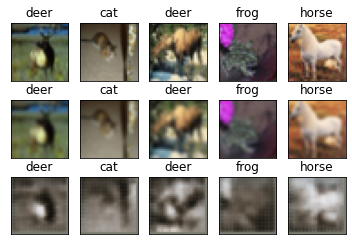

Epoch : [186/400] 

0.008690569945885903
Epoch : [187/400] 

0.00865248929541326
Epoch : [188/400] 

0.008613948848398995
Epoch : [189/400] 

0.008574953456564732
Epoch : [190/400] 

0.008535508028903498
Training Loss: 0.016408	 validation Loss 0.016540
Class:deer 	 PNSR :15.990755475216577 	 SSIM : 0.7909242821835174
Class:cat 	 PNSR :19.8345381129859 	 SSIM : 0.7927838949515363
Class:deer 	 PNSR :14.214414684476315 	 SSIM : 0.747301822156531
Class:frog 	 PNSR :9.924161288537716 	 SSIM : 0.7030196906070924
Class:horse 	 PNSR :10.638701738793113 	 SSIM : 0.7081700802687824


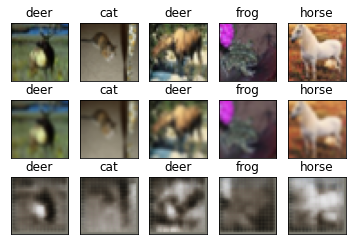

Epoch : [191/400] 

0.008495617531061752
Epoch : [192/400] 

0.008455286984714275
Epoch : [193/400] 

0.008414521466932008
Epoch : [194/400] 

0.008373326109542925
Epoch : [195/400] 

0.008331706098485997
Training Loss: 0.016411	 validation Loss 0.016649
Class:deer 	 PNSR :15.925339327278262 	 SSIM : 0.7907779236518914
Class:cat 	 PNSR :19.94294526091474 	 SSIM : 0.7911282064619622
Class:deer 	 PNSR :14.118564025023373 	 SSIM : 0.7458178490178392
Class:frog 	 PNSR :9.928680448704036 	 SSIM : 0.7038932865346208
Class:horse 	 PNSR :10.662719105296459 	 SSIM : 0.7120474496546801


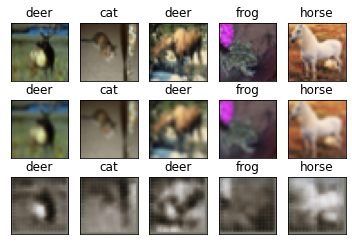

Epoch : [196/400] 

0.008289666673158355
Epoch : [197/400] 

0.008247213125755716
Epoch : [198/400] 

0.00820435080060618
Epoch : [199/400] 

0.008161085093497437
Epoch : [200/400] 

0.008117421450997522
Training Loss: 0.016568	 validation Loss 0.016254
Class:deer 	 PNSR :15.905592042654867 	 SSIM : 0.7930307874002388
Class:cat 	 PNSR :20.144997256438263 	 SSIM : 0.7980699388485464
Class:deer 	 PNSR :13.871803422519658 	 SSIM : 0.7458224553464272
Class:frog 	 PNSR :9.801630484374616 	 SSIM : 0.6995709033580283
Class:horse 	 PNSR :10.785426559289197 	 SSIM : 0.7176946463928022


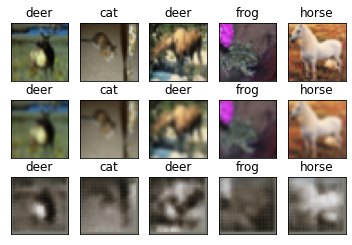

Epoch : [201/400] 

0.00807336536976915
Epoch : [202/400] 

0.008028922395877781
Epoch : [203/400] 

0.007984098124093428
Epoch : [204/400] 

0.007938898197186363
Epoch : [205/400] 

0.007893328305216751
Training Loss: 0.016325	 validation Loss 0.016472
Class:deer 	 PNSR :15.955363595506 	 SSIM : 0.7922309041767313
Class:cat 	 PNSR :19.93816081837423 	 SSIM : 0.7919927702194474
Class:deer 	 PNSR :13.964194559213976 	 SSIM : 0.7449975444387662
Class:frog 	 PNSR :9.819188816051355 	 SSIM : 0.7040796119802225
Class:horse 	 PNSR :10.743339153004804 	 SSIM : 0.7146851825321893


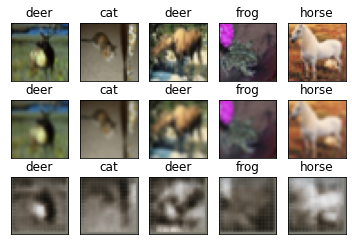

Epoch : [206/400] 

0.00784739418481838
Epoch : [207/400] 

0.007801101618476457
Epoch : [208/400] 

0.007754456433799706
Epoch : [209/400] 

0.007707464502786725
Epoch : [210/400] 

0.007660131741086796
Training Loss: 0.016287	 validation Loss 0.016489
Class:deer 	 PNSR :15.78114326060361 	 SSIM : 0.7781683072383832
Class:cat 	 PNSR :19.554346657714806 	 SSIM : 0.784937859789043
Class:deer 	 PNSR :14.008487230887583 	 SSIM : 0.739878885373834
Class:frog 	 PNSR :9.808849659531305 	 SSIM : 0.6896255144502298
Class:horse 	 PNSR :10.700351809468458 	 SSIM : 0.7086728327178758


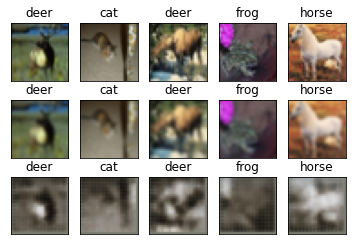

Epoch : [211/400] 

0.007612464107255182
Epoch : [212/400] 

0.0075644676020030195
Epoch : [213/400] 

0.007516148267441917
Epoch : [214/400] 

0.007467512186323329
Epoch : [215/400] 

0.007418565481272825
Training Loss: 0.016367	 validation Loss 0.016407
Class:deer 	 PNSR :15.933826842006143 	 SSIM : 0.7751361695064928
Class:cat 	 PNSR :19.923456717017775 	 SSIM : 0.7751309547473783
Class:deer 	 PNSR :13.945326700406635 	 SSIM : 0.7394206939168043
Class:frog 	 PNSR :9.781752784255985 	 SSIM : 0.6780944213596184
Class:horse 	 PNSR :10.75603208772467 	 SSIM : 0.7049600096739937


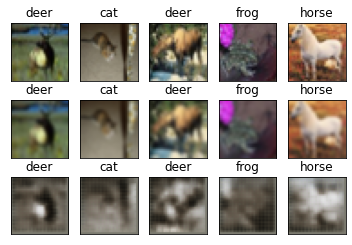

Epoch : [216/400] 

0.00736931431401933
Epoch : [217/400] 

0.0073197648846194474
Epoch : [218/400] 

0.007269923430676955
Epoch : [219/400] 

0.007219796226557576
Epoch : [220/400] 

0.0071693895825991226
Training Loss: 0.016260	 validation Loss 0.016128
Class:deer 	 PNSR :15.939257712017444 	 SSIM : 0.7844789675569208
Class:cat 	 PNSR :19.7992017315299 	 SSIM : 0.7998443483164491
Class:deer 	 PNSR :14.156692605901778 	 SSIM : 0.7442867283080131
Class:frog 	 PNSR :9.9471408510449 	 SSIM : 0.6950279438425065
Class:horse 	 PNSR :10.563289366392794 	 SSIM : 0.7201411186242294


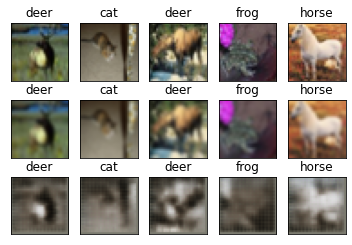

Epoch : [221/400] 

0.0071187098443171015
Epoch : [222/400] 

0.007067763391605915
Epoch : [223/400] 

0.0070165566379356975
Epoch : [224/400] 

0.006965096029544968
Epoch : [225/400] 

0.006913388044629117
Training Loss: 0.016187	 validation Loss 0.016125
Class:deer 	 PNSR :15.928659352421583 	 SSIM : 0.786022779549184
Class:cat 	 PNSR :19.78460732405368 	 SSIM : 0.797012808203843
Class:deer 	 PNSR :14.09264434660303 	 SSIM : 0.7453576765978172
Class:frog 	 PNSR :9.92716049349042 	 SSIM : 0.6989199950307162
Class:horse 	 PNSR :10.591604644295549 	 SSIM : 0.718412368353186


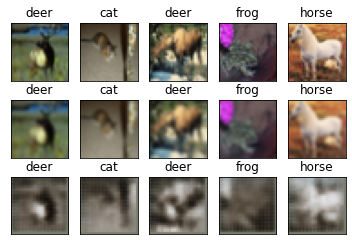

Epoch : [226/400] 

0.006861439192524905
Epoch : [227/400] 

0.006809256012891013
Epoch : [228/400] 

0.006756845074884794
Epoch : [229/400] 

0.006704212976335301
Epoch : [230/400] 

0.006651366342912713
Training Loss: 0.016170	 validation Loss 0.016098
Class:deer 	 PNSR :15.934471386721107 	 SSIM : 0.7891253519944165
Class:cat 	 PNSR :19.845876706729072 	 SSIM : 0.7992302279934527
Class:deer 	 PNSR :14.052191452306511 	 SSIM : 0.7457185782357585
Class:frog 	 PNSR :9.913942531468853 	 SSIM : 0.7007258954401906
Class:horse 	 PNSR :10.563937406083477 	 SSIM : 0.722577628539231


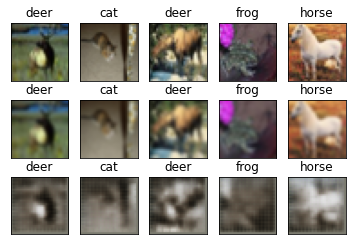

Epoch : [231/400] 

0.006598311827294254
Epoch : [232/400] 

0.006545056108326702
Epoch : [233/400] 

0.006491605890185626
Epoch : [234/400] 

0.006437967901531407
Epoch : [235/400] 

0.006384148894662201
Training Loss: 0.016218	 validation Loss 0.016086
Class:deer 	 PNSR :16.028083130308342 	 SSIM : 0.7902134453202908
Class:cat 	 PNSR :19.896679034543073 	 SSIM : 0.8012723405801895
Class:deer 	 PNSR :13.943709331722454 	 SSIM : 0.7461037204418944
Class:frog 	 PNSR :9.859843017151032 	 SSIM : 0.7006855739707926
Class:horse 	 PNSR :10.582957029844591 	 SSIM : 0.7179133210695895


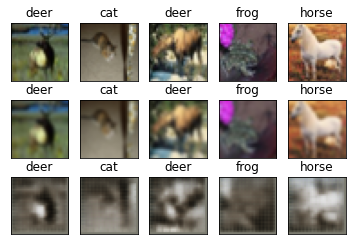

Epoch : [236/400] 

0.006330155644663909
Epoch : [237/400] 

0.006275994948557289
Epoch : [238/400] 

0.006221673624442305
Epoch : [239/400] 

0.006167198510639811
Epoch : [240/400] 

0.006112576464830711
Training Loss: 0.016133	 validation Loss 0.016127
Class:deer 	 PNSR :15.983081145508208 	 SSIM : 0.7894130817429272
Class:cat 	 PNSR :19.85831869441131 	 SSIM : 0.801662980045195
Class:deer 	 PNSR :14.113460138077654 	 SSIM : 0.7445647950321052
Class:frog 	 PNSR :9.889736620371561 	 SSIM : 0.6999745422865552
Class:horse 	 PNSR :10.519377968418645 	 SSIM : 0.7225153818136628


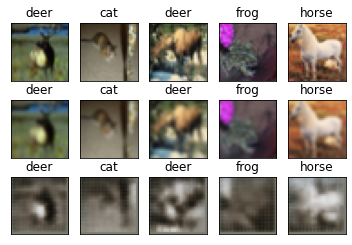

Epoch : [241/400] 

0.00605781436319266
Epoch : [242/400] 

0.0060029190995344525
Epoch : [243/400] 

0.005947897584428178
Epoch : [244/400] 

0.005892756744339283
Epoch : [245/400] 

0.005837503520754616
Training Loss: 0.016116	 validation Loss 0.016145
Class:deer 	 PNSR :16.00449115372222 	 SSIM : 0.7904503993886073
Class:cat 	 PNSR :19.95956493571617 	 SSIM : 0.7995054214835088
Class:deer 	 PNSR :14.056289979553402 	 SSIM : 0.7445139942384121
Class:frog 	 PNSR :9.878472815455208 	 SSIM : 0.6983218560089045
Class:horse 	 PNSR :10.520420714380883 	 SSIM : 0.7200102835723946


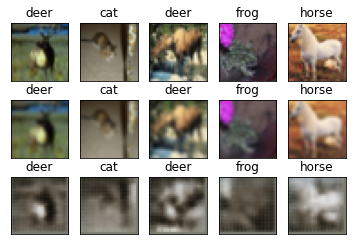

Epoch : [246/400] 

0.0057821448693085855
Epoch : [247/400] 

0.005726687758907547
Epoch : [248/400] 

0.00567113917085251
Epoch : [249/400] 

0.005615506097960281
Epoch : [250/400] 

0.005559795543683166
Training Loss: 0.016087	 validation Loss 0.016108
Class:deer 	 PNSR :16.13887991631058 	 SSIM : 0.7920922414768148
Class:cat 	 PNSR :20.187546520905716 	 SSIM : 0.7982765162269737
Class:deer 	 PNSR :14.112855315204037 	 SSIM : 0.744756300720919
Class:frog 	 PNSR :9.892467493460522 	 SSIM : 0.7010234990717105
Class:horse 	 PNSR :10.56593813405171 	 SSIM : 0.7207837093074106


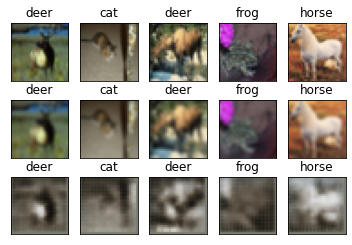

Epoch : [251/400] 

0.005504014521227334
Epoch : [252/400] 

0.0054481700526699435
Epoch : [253/400] 

0.005392269168075162
Epoch : [254/400] 

0.005336318904609169
Epoch : [255/400] 

0.005280326305654283
Training Loss: 0.016024	 validation Loss 0.015936
Class:deer 	 PNSR :16.28993980404921 	 SSIM : 0.7990502390749651
Class:cat 	 PNSR :20.3759205084391 	 SSIM : 0.8023763014050437
Class:deer 	 PNSR :14.258763119425431 	 SSIM : 0.7538760498352959
Class:frog 	 PNSR :9.910200560792056 	 SSIM : 0.700916151500151
Class:horse 	 PNSR :10.655212875568374 	 SSIM : 0.7202735514438735


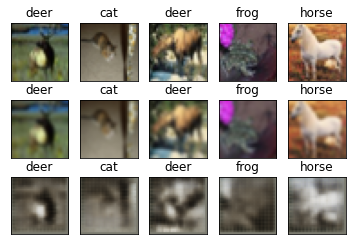

Epoch : [256/400] 

0.005224298419922287
Epoch : [257/400] 

0.005168242300567089
Epoch : [258/400] 

0.005112165004296832
Epoch : [259/400] 

0.005056073590485546
Epoch : [260/400] 

0.004999975120284468
Training Loss: 0.015938	 validation Loss 0.015939
Class:deer 	 PNSR :16.356242319757722 	 SSIM : 0.8026032207156999
Class:cat 	 PNSR :20.821779216119367 	 SSIM : 0.7993804561267158
Class:deer 	 PNSR :14.393121085018294 	 SSIM : 0.7602360195128007
Class:frog 	 PNSR :9.886977198101212 	 SSIM : 0.7034752767662207
Class:horse 	 PNSR :10.600790808990222 	 SSIM : 0.7216719212194542


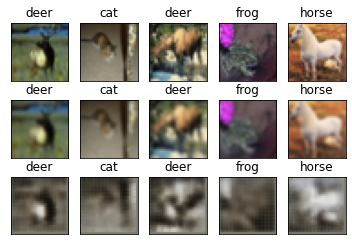

Epoch : [261/400] 

0.004943876655733141
Epoch : [262/400] 

0.004887785258870394
Epoch : [263/400] 

0.0048317079908453305
Epoch : [264/400] 

0.004775651911028425
Epoch : [265/400] 

0.004719624076122843
Training Loss: 0.015912	 validation Loss 0.015891
Class:deer 	 PNSR :16.394811998267453 	 SSIM : 0.806922657995467
Class:cat 	 PNSR :20.896492910596155 	 SSIM : 0.8025262017335563
Class:deer 	 PNSR :14.563130607256177 	 SSIM : 0.7612848816825024
Class:frog 	 PNSR :9.89304392903116 	 SSIM : 0.7043265676245639
Class:horse 	 PNSR :10.550327167842218 	 SSIM : 0.7224938535395978


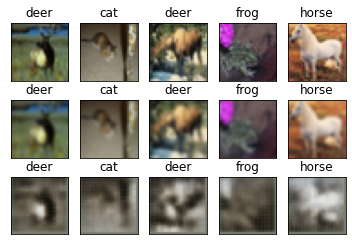

Epoch : [266/400] 

0.004663631539276096
Epoch : [267/400] 

0.004607681349192149
Epoch : [268/400] 

0.004551780549244076
Epoch : [269/400] 

0.004495936176587406
Epoch : [270/400] 

0.004440155261274235
Training Loss: 0.015895	 validation Loss 0.015916
Class:deer 	 PNSR :16.410164275186688 	 SSIM : 0.8058393667620942
Class:cat 	 PNSR :20.831713592086082 	 SSIM : 0.8004704875585755
Class:deer 	 PNSR :14.666227857931455 	 SSIM : 0.7608948067670868
Class:frog 	 PNSR :9.915931993667687 	 SSIM : 0.7036970948677687
Class:horse 	 PNSR :10.516610927116318 	 SSIM : 0.7225506660338158


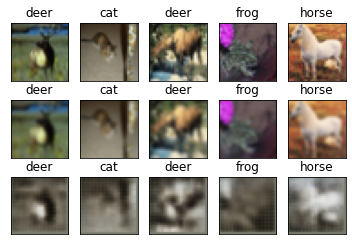

Epoch : [271/400] 

0.004384444825368232
Epoch : [272/400] 

0.0043288118820606625
Epoch : [273/400] 

0.004273263434787522
Epoch : [274/400] 

0.004217806476347896
Epoch : [275/400] 

0.004162447988023663
Training Loss: 0.015877	 validation Loss 0.015927
Class:deer 	 PNSR :16.427767764783617 	 SSIM : 0.8056079097482906
Class:cat 	 PNSR :20.77519131349115 	 SSIM : 0.8011450179109727
Class:deer 	 PNSR :14.75019563773185 	 SSIM : 0.7607680513528017
Class:frog 	 PNSR :9.930228956736949 	 SSIM : 0.7038649050253952
Class:horse 	 PNSR :10.485174717210334 	 SSIM : 0.723439271496601


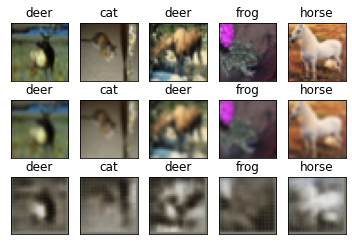

Epoch : [276/400] 

0.0041071949387006396
Epoch : [277/400] 

0.004052054283991303
Epoch : [278/400] 

0.00399703296535916
Epoch : [279/400] 

0.003942137909244927
Epoch : [280/400] 

0.003887376026194566
Training Loss: 0.015859	 validation Loss 0.015839
Class:deer 	 PNSR :16.41705814345785 	 SSIM : 0.8051517122778541
Class:cat 	 PNSR :20.726464581480588 	 SSIM : 0.8007913363102223
Class:deer 	 PNSR :14.756999453515487 	 SSIM : 0.7608898573602648
Class:frog 	 PNSR :9.922084466085895 	 SSIM : 0.7020936877483298
Class:horse 	 PNSR :10.474980849212521 	 SSIM : 0.7272482461191504


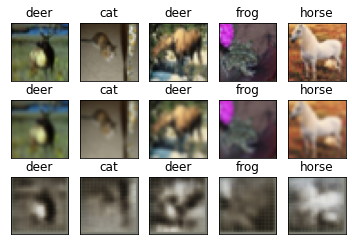

Epoch : [281/400] 

0.0038327542099893526
Epoch : [282/400] 

0.0037782793367780406
Epoch : [283/400] 

0.0037239582642112426
Epoch : [284/400] 

0.0036697978305781516
Epoch : [285/400] 

0.0036158048539456857
Training Loss: 0.015835	 validation Loss 0.015823
Class:deer 	 PNSR :16.374163431686746 	 SSIM : 0.8048114529096128
Class:cat 	 PNSR :20.69362315113354 	 SSIM : 0.7988735093359463
Class:deer 	 PNSR :14.761611319720117 	 SSIM : 0.7623381380658634
Class:frog 	 PNSR :9.915409949284367 	 SSIM : 0.700894309819687
Class:horse 	 PNSR :10.46053680997304 	 SSIM : 0.7313271239394266


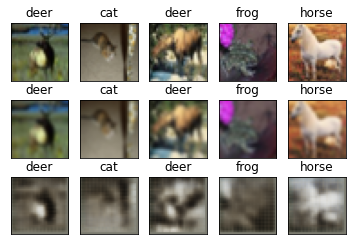

Epoch : [286/400] 

0.0035619861313001874
Epoch : [287/400] 

0.003508348437691786
Epoch : [288/400] 

0.0034548985253814875
Epoch : [289/400] 

0.003401643122991178
Epoch : [290/400] 

0.00334858893465657
Training Loss: 0.015822	 validation Loss 0.015843
Class:deer 	 PNSR :16.314647125608285 	 SSIM : 0.8048253434244393
Class:cat 	 PNSR :20.788433003499694 	 SSIM : 0.7952341121318004
Class:deer 	 PNSR :14.597534467020072 	 SSIM : 0.7620634129442528
Class:frog 	 PNSR :9.870710212408795 	 SSIM : 0.6988341748165275
Class:horse 	 PNSR :10.50265715297201 	 SSIM : 0.7300440899718197


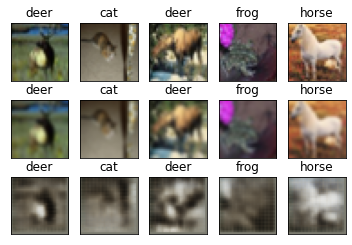

Epoch : [291/400] 

0.0032957426391832445
Epoch : [292/400] 

0.0032431108892058778
Epoch : [293/400] 

0.003190700310350772
Epoch : [294/400] 

0.003138517500401766
Epoch : [295/400] 

0.003086569028469674
Training Loss: 0.015795	 validation Loss 0.015833
Class:deer 	 PNSR :16.296989091763365 	 SSIM : 0.8031670322984598
Class:cat 	 PNSR :20.778433960695768 	 SSIM : 0.7916970028021271
Class:deer 	 PNSR :14.564775195357205 	 SSIM : 0.7628456547445092
Class:frog 	 PNSR :9.860549876762892 	 SSIM : 0.6972000391023433
Class:horse 	 PNSR :10.49476700516275 	 SSIM : 0.7275415516937561


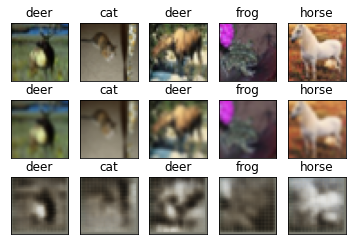

Epoch : [296/400] 

0.0030348614341653233
Epoch : [297/400] 

0.0029834012267762953
Epoch : [298/400] 

0.0029321948844475035
Epoch : [299/400] 

0.002881248853365682
Epoch : [300/400] 

0.0028305695469478913
Training Loss: 0.015776	 validation Loss 0.015829
Class:deer 	 PNSR :16.29635774185373 	 SSIM : 0.8025138781751583
Class:cat 	 PNSR :20.764878257072006 	 SSIM : 0.7911681277197343
Class:deer 	 PNSR :14.594602676903907 	 SSIM : 0.7632302022265582
Class:frog 	 PNSR :9.85657528714746 	 SSIM : 0.6966946819697287
Class:horse 	 PNSR :10.499972988455927 	 SSIM : 0.7263811147524039


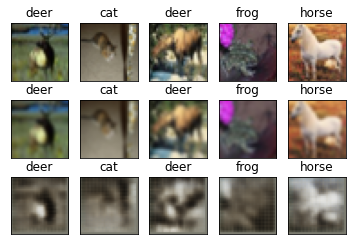

Epoch : [301/400] 

0.0027801633450341636
Epoch : [302/400] 

0.002730036593084362
Epoch : [303/400] 

0.0026801956013793745
Epoch : [304/400] 

0.0026306466442267357
Epoch : [305/400] 

0.0025813959591707725
Training Loss: 0.015759	 validation Loss 0.015764
Class:deer 	 PNSR :16.305889126887422 	 SSIM : 0.8041512317086723
Class:cat 	 PNSR :20.613692481434196 	 SSIM : 0.7951909537935515
Class:deer 	 PNSR :14.70558641512661 	 SSIM : 0.764237075716685
Class:frog 	 PNSR :9.887109925590849 	 SSIM : 0.6984635734369755
Class:horse 	 PNSR :10.477566533312249 	 SSIM : 0.7302941267742432


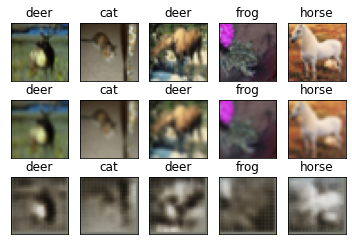

Epoch : [306/400] 

0.002532449746207388
Epoch : [307/400] 

0.0024838141670035594
Epoch : [308/400] 

0.002435495344121671
Epoch : [309/400] 

0.0023874993602487657
Epoch : [310/400] 

0.0023398322574308154
Training Loss: 0.015741	 validation Loss 0.015774
Class:deer 	 PNSR :16.288337832881513 	 SSIM : 0.8048122999172936
Class:cat 	 PNSR :20.719093550748184 	 SSIM : 0.7914928161431639
Class:deer 	 PNSR :14.614047961706902 	 SSIM : 0.763569496714041
Class:frog 	 PNSR :9.852662821383365 	 SSIM : 0.6974352375263195
Class:horse 	 PNSR :10.534286127374576 	 SSIM : 0.7329879683598538


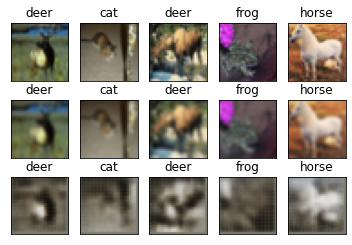

Epoch : [311/400] 

0.0022925000363121107
Epoch : [312/400] 

0.0022455086553798617
Epoch : [313/400] 

0.002198864030214101
Epoch : [314/400] 

0.0021525720327429973
Epoch : [315/400] 

0.002106638490503654
Training Loss: 0.015726	 validation Loss 0.015799
Class:deer 	 PNSR :16.218251654622126 	 SSIM : 0.8048752781337943
Class:cat 	 PNSR :20.770006853000233 	 SSIM : 0.7932331322632719
Class:deer 	 PNSR :14.462099578986717 	 SSIM : 0.7637919800420786
Class:frog 	 PNSR :9.815226764725498 	 SSIM : 0.6987357698622884
Class:horse 	 PNSR :10.612175353317873 	 SSIM : 0.7312892172026819


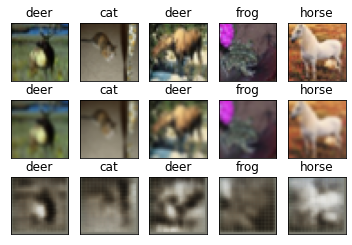

Epoch : [316/400] 

0.0020610691859085047
Epoch : [317/400] 

0.0020158698555173844
Epoch : [318/400] 

0.0019710461893153726
Epoch : [319/400] 

0.001926603829996504
Epoch : [320/400] 

0.0018825483722534264
Training Loss: 0.015713	 validation Loss 0.015883
Class:deer 	 PNSR :16.177078376451576 	 SSIM : 0.8048688837613196
Class:cat 	 PNSR :20.714602546965224 	 SSIM : 0.7953086597504267
Class:deer 	 PNSR :14.391485073100824 	 SSIM : 0.7647610218171023
Class:frog 	 PNSR :9.810007564062431 	 SSIM : 0.7020518429845755
Class:horse 	 PNSR :10.682049685996784 	 SSIM : 0.7289586390889261


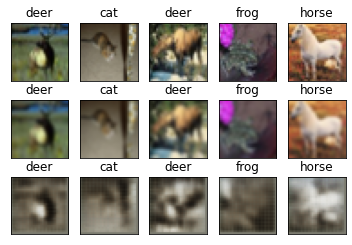

Epoch : [321/400] 

0.0018388853620731076
Epoch : [322/400] 

0.0017956202960386681
Epoch : [323/400] 

0.0017527586206374359
Epoch : [324/400] 

0.0017103057315753093
Epoch : [325/400] 

0.0016682669730975072
Training Loss: 0.015699	 validation Loss 0.015832
Class:deer 	 PNSR :16.245558305024794 	 SSIM : 0.805137681070227
Class:cat 	 PNSR :20.740507457609 	 SSIM : 0.7966368454178635
Class:deer 	 PNSR :14.45499472053007 	 SSIM : 0.7651823859147241
Class:frog 	 PNSR :9.821520703909615 	 SSIM : 0.7029290520739052
Class:horse 	 PNSR :10.747160280283847 	 SSIM : 0.7291233672842082


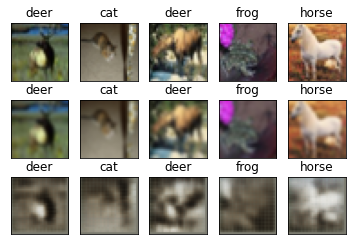

Epoch : [326/400] 

0.0016266476373158036
Epoch : [327/400] 

0.0015854529635423217
Epoch : [328/400] 

0.0015446881376299743
Epoch : [329/400] 

0.001504358291319635
Epoch : [330/400] 

0.0014644685015941217
Training Loss: 0.015686	 validation Loss 0.015828
Class:deer 	 PNSR :16.30278966689227 	 SSIM : 0.8043879089492005
Class:cat 	 PNSR :20.740827883551788 	 SSIM : 0.7995012201298275
Class:deer 	 PNSR :14.471205500775238 	 SSIM : 0.7644920361440765
Class:frog 	 PNSR :9.806552416415737 	 SSIM : 0.7016060330193419
Class:horse 	 PNSR :10.786533638128258 	 SSIM : 0.7285929301479263


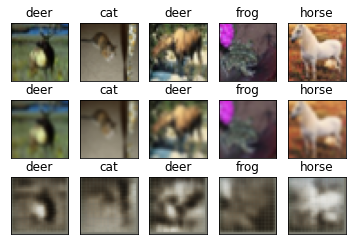

Epoch : [331/400] 

0.0014250237900390746
Epoch : [332/400] 

0.0013860291222108038
Epoch : [333/400] 

0.0013474894070111935
Epoch : [334/400] 

0.0013094094960697396
Epoch : [335/400] 

0.0012717941831327931
Training Loss: 0.015671	 validation Loss 0.015765
Class:deer 	 PNSR :16.386379916460864 	 SSIM : 0.8050034133733902
Class:cat 	 PNSR :20.755042002825537 	 SSIM : 0.7993026651507993
Class:deer 	 PNSR :14.529090331460289 	 SSIM : 0.7650220150090158
Class:frog 	 PNSR :9.78445875613132 	 SSIM : 0.701138704573755
Class:horse 	 PNSR :10.796956329402349 	 SSIM : 0.7302364869128826


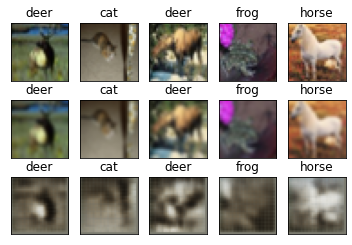

Epoch : [336/400] 

0.0012346482034600917
Epoch : [337/400] 

0.001197976233228657
Epoch : [338/400] 

0.001161782888944124
Epoch : [339/400] 

0.001126072726859588
Epoch : [340/400] 

0.001090850242402033
Training Loss: 0.015654	 validation Loss 0.015739
Class:deer 	 PNSR :16.39583175061827 	 SSIM : 0.8039325638205558
Class:cat 	 PNSR :20.768978331669537 	 SSIM : 0.8005195223387992
Class:deer 	 PNSR :14.537340281290376 	 SSIM : 0.7642429560697761
Class:frog 	 PNSR :9.795849632787958 	 SSIM : 0.6993848174020728
Class:horse 	 PNSR :10.775149055106443 	 SSIM : 0.7283723617183785


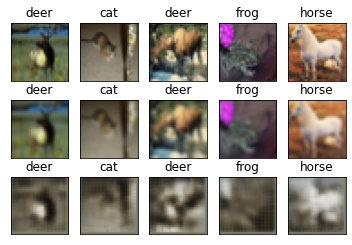

Epoch : [341/400] 

0.0010561198696064165
Epoch : [342/400] 

0.0010218859805574878
Epoch : [343/400] 

0.0009881528848393992
Epoch : [344/400] 

0.0009549248289931862
Epoch : [345/400] 

0.0009222059959821898
Training Loss: 0.015624	 validation Loss 0.015702
Class:deer 	 PNSR :16.39576825161004 	 SSIM : 0.8046098871324966
Class:cat 	 PNSR :20.761894431907493 	 SSIM : 0.7996721042923763
Class:deer 	 PNSR :14.536387899814194 	 SSIM : 0.765850579076342
Class:frog 	 PNSR :9.81021136738902 	 SSIM : 0.7002854846784595
Class:horse 	 PNSR :10.77934711757386 	 SSIM : 0.7304433156824279


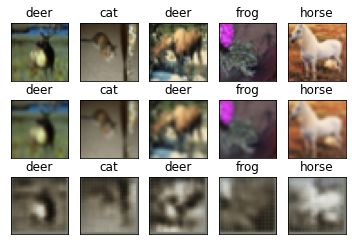

Epoch : [346/400] 

0.0008900005046654741
Epoch : [347/400] 

0.0008583124092793191
Epoch : [348/400] 

0.0008271456989268461
Epoch : [349/400] 

0.0007965042970758457
Epoch : [350/400] 

0.0007663920610648637
Training Loss: 0.015603	 validation Loss 0.015650
Class:deer 	 PNSR :16.485398521478317 	 SSIM : 0.8045195367154765
Class:cat 	 PNSR :20.878826971439594 	 SSIM : 0.7996135782000278
Class:deer 	 PNSR :14.605835694677829 	 SSIM : 0.7660410609520326
Class:frog 	 PNSR :9.839919747285112 	 SSIM : 0.7002102137837651
Class:horse 	 PNSR :10.773171397195206 	 SSIM : 0.7319965314247817


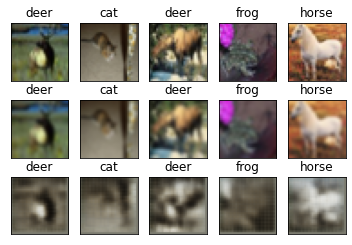

Epoch : [351/400] 

0.0007368127816176147
Epoch : [352/400] 

0.000707770182365784
Epoch : [353/400] 

0.0006792679193802686
Epoch : [354/400] 

0.0006513095807109302
Epoch : [355/400] 

0.0006238986859349069
Training Loss: 0.015583	 validation Loss 0.015623
Class:deer 	 PNSR :16.53106513156018 	 SSIM : 0.804718962635918
Class:cat 	 PNSR :20.86610008091169 	 SSIM : 0.8020688803906765
Class:deer 	 PNSR :14.648904482395217 	 SSIM : 0.7651081584441942
Class:frog 	 PNSR :9.847038904070505 	 SSIM : 0.7007391371846587
Class:horse 	 PNSR :10.724457734004275 	 SSIM : 0.7335830433361323


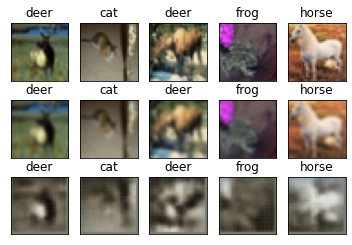

Epoch : [356/400] 

0.0005970386857135457
Epoch : [357/400] 

0.0005707329613580124
Epoch : [358/400] 

0.0005449848244036287
Epoch : [359/400] 

0.0005197975161929952
Epoch : [360/400] 

0.0004951742074679505
Training Loss: 0.015555	 validation Loss 0.015618
Class:deer 	 PNSR :16.52632822166481 	 SSIM : 0.8061773688799997
Class:cat 	 PNSR :21.052865588707736 	 SSIM : 0.80174705605091
Class:deer 	 PNSR :14.68966392998855 	 SSIM : 0.7642613788778913
Class:frog 	 PNSR :9.834709429604953 	 SSIM : 0.7015301906679677
Class:horse 	 PNSR :10.691025692786464 	 SSIM : 0.731176307281666


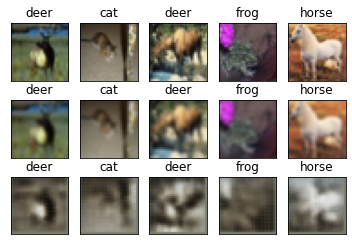

Epoch : [361/400] 

0.00047111799797041617
Epoch : [362/400] 

0.0004476319160521834
Epoch : [363/400] 

0.00042471891829368294
Epoch : [364/400] 

0.0004023818891317915
Epoch : [365/400] 

0.00038062364049672105
Training Loss: 0.015537	 validation Loss 0.015597
Class:deer 	 PNSR :16.58005901586164 	 SSIM : 0.8070022020191092
Class:cat 	 PNSR :21.106662875421787 	 SSIM : 0.8022735003533019
Class:deer 	 PNSR :14.751793757784505 	 SSIM : 0.763826500615763
Class:frog 	 PNSR :9.829057057637865 	 SSIM : 0.7011830552944206
Class:horse 	 PNSR :10.697249743086187 	 SSIM : 0.7304226491836495


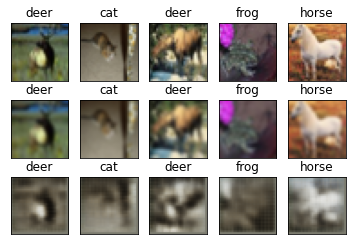

Epoch : [366/400] 

0.0003594469114580332
Epoch : [367/400] 

0.0003388543678798299
Epoch : [368/400] 

0.00031884860208515354
Epoch : [369/400] 

0.0002994321325296523
Epoch : [370/400] 

0.0002806074034845385
Training Loss: 0.015524	 validation Loss 0.015585
Class:deer 	 PNSR :16.535346724766413 	 SSIM : 0.8069899693463455
Class:cat 	 PNSR :21.148715015261253 	 SSIM : 0.8043923775492378
Class:deer 	 PNSR :14.694695492829501 	 SSIM : 0.7624106481660261
Class:frog 	 PNSR :9.822211414025743 	 SSIM : 0.7018454832118493
Class:horse 	 PNSR :10.728744059214288 	 SSIM : 0.7311731802517049


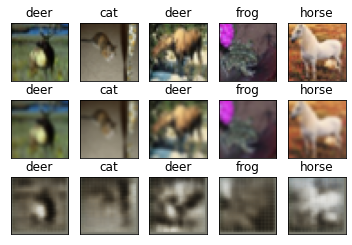

Epoch : [371/400] 

0.00026237678472888824
Epoch : [372/400] 

0.0002447425712513179
Epoch : [373/400] 

0.00022770698296107643
Epoch : [374/400] 

0.00021127216440858937
Epoch : [375/400] 

0.0001954401845154873
Training Loss: 0.015513	 validation Loss 0.015593
Class:deer 	 PNSR :16.478487805902372 	 SSIM : 0.8054935032714381
Class:cat 	 PNSR :21.108107091238093 	 SSIM : 0.8029649051700481
Class:deer 	 PNSR :14.726953253606961 	 SSIM : 0.7624710439777115
Class:frog 	 PNSR :9.83317342811518 	 SSIM : 0.6983158162975268
Class:horse 	 PNSR :10.704880424670943 	 SSIM : 0.7328298106822025


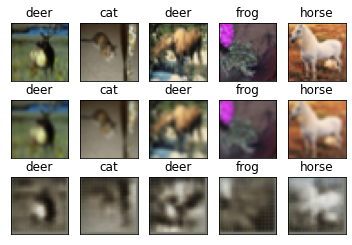

Epoch : [376/400] 

0.00018021303631415912
Epoch : [377/400] 

0.0001655926366968527
Epoch : [378/400] 

0.00015158082617436775
Epoch : [379/400] 

0.0001381793686443576
Epoch : [380/400] 

0.00012538995116927995
Training Loss: 0.015504	 validation Loss 0.015569
Class:deer 	 PNSR :16.49028277277854 	 SSIM : 0.8066293305225801
Class:cat 	 PNSR :21.2100482754914 	 SSIM : 0.8029551792704921
Class:deer 	 PNSR :14.694697400371325 	 SSIM : 0.7635161062282788
Class:frog 	 PNSR :9.839268622329586 	 SSIM : 0.7005542702440151
Class:horse 	 PNSR :10.74042841005387 	 SSIM : 0.7331814661418431


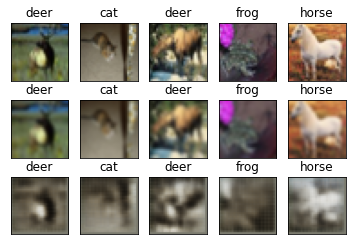

Epoch : [381/400] 

0.0001132141837640166
Epoch : [382/400] 

0.00010165359919319782
Epoch : [383/400] 

9.070965277824384e-05
Epoch : [384/400] 

8.038372221416196e-05
Epoch : [385/400] 

7.067710739611326e-05
Training Loss: 0.015496	 validation Loss 0.015562
Class:deer 	 PNSR :16.425789467651025 	 SSIM : 0.8070595366023691
Class:cat 	 PNSR :21.2167361782833 	 SSIM : 0.8029163379539329
Class:deer 	 PNSR :14.608469317621523 	 SSIM : 0.7642359340474347
Class:frog 	 PNSR :9.846261780935613 	 SSIM : 0.7017008687350966
Class:horse 	 PNSR :10.756896346309068 	 SSIM : 0.7334001816458414


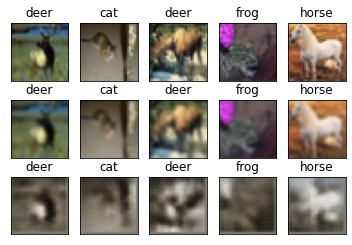

Epoch : [386/400] 

6.159103025577304e-05
Epoch : [387/400] 

5.312663460750559e-05
Epoch : [388/400] 

4.5284986004373833e-05
Epoch : [389/400] 

3.8067071604001055e-05
Epoch : [390/400] 

3.147380004430136e-05
Training Loss: 0.015489	 validation Loss 0.015559
Class:deer 	 PNSR :16.43693838869615 	 SSIM : 0.8070697362167368
Class:cat 	 PNSR :21.268734414653988 	 SSIM : 0.803275045868792
Class:deer 	 PNSR :14.616372288630632 	 SSIM : 0.7638757308514389
Class:frog 	 PNSR :9.849565515056685 	 SSIM : 0.702542227159844
Class:horse 	 PNSR :10.753993827370824 	 SSIM : 0.7342656319907216


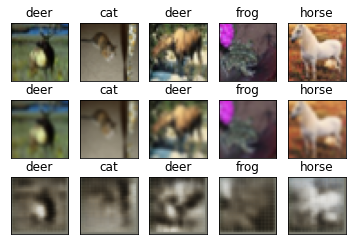

Epoch : [391/400] 

2.5506001329091625e-05
Epoch : [392/400] 

2.0164426723609392e-05
Epoch : [393/400] 

1.5449748659936678e-05
Epoch : [394/400] 

1.1362560652348019e-05
Epoch : [395/400] 

7.90337722259888e-06
Training Loss: 0.015485	 validation Loss 0.015554
Class:deer 	 PNSR :16.454879463693917 	 SSIM : 0.8067699718544391
Class:cat 	 PNSR :21.26992875389488 	 SSIM : 0.8034798212487789
Class:deer 	 PNSR :14.6369304423445 	 SSIM : 0.763922702249439
Class:frog 	 PNSR :9.851652968146412 	 SSIM : 0.7028345968693138
Class:horse 	 PNSR :10.746379032547367 	 SSIM : 0.7343912774989163


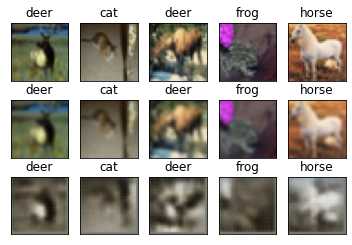

Epoch : [396/400] 

5.072633835151046e-06
Epoch : [397/400] 

2.8706868423555885e-06
Epoch : [398/400] 

1.2978134395922622e-06
Epoch : [399/400] 

3.542116303736692e-07
Epoch : [400/400] 

4.000020141974123e-08
Training Loss: 0.015483	 validation Loss 0.015552
Class:deer 	 PNSR :16.480816537423728 	 SSIM : 0.8068003637424548
Class:cat 	 PNSR :21.279924335446477 	 SSIM : 0.8033212755807372
Class:deer 	 PNSR :14.660733238681093 	 SSIM : 0.76385047088405
Class:frog 	 PNSR :9.855805846078617 	 SSIM : 0.7029965055662007
Class:horse 	 PNSR :10.737294528180614 	 SSIM : 0.7344631418866562


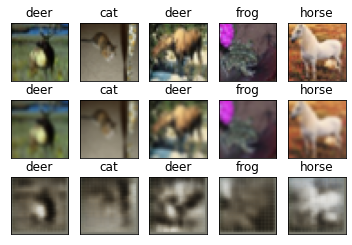

execution time : 123.7min


In [ ]:

weak_train_loss_graph = np.array([])
moderate_val_loss_graph = np.array([])

start = time.time()

for epoch in range(1, n_epochs+1):
    print(f"Epoch : [{epoch}/{n_epochs}]","\n")
    model_weak.train()
    # monitor training loss
    train_loss = 0.0
    total_train_loss = 0.0
    val_los = 0.0
    total_val_loss = 0.0
    tr_loader_iter = iter(tr_loader)
    '''
    Total되는 새로운 변수를 하나 만들어줘야지 val_loss가 제대로 더해진다. 안 하면 이상하게 안 더해진다.
    '''

    #Training
    for i, (hat_input) in enumerate(hat_tr_dataloader):
        
        images, _ = tr_loader_iter.next()
        hat_images, _ = hat_input
        images = images.to(device)
 #check       print(images.shape)
        hat_images = hat_images.to(device)        
        optimizer.zero_grad()
 
#check0. print(hat_images.shape)  -> torch.Size([32, 3, 32, 32])

        outputs = model(hat_images)
#check      print(outputs.shape)
        loss = mse_loss(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        total_train_loss += train_loss

#check1.        print(f"minibatch : {i}, train_loss_added : {total_train_loss/1250}")
    total_train_loss = total_train_loss/len(tr_loader)
    train_loss_graph = np.append(train_loss_graph, total_train_loss)


    #evaluation
    model.eval()

    with torch.no_grad():   
        optimizer.zero_grad()
        
        val_loader_iter = iter(val_loader)
        hat_val_iter    = iter(hat_val_dataloader)



      for i in range(len(val_loader)):
        """
        enumerate는 메모리 누설로 batch를 잃어버리는 현상 발생
        """

      
        images, labels = val_loader_iter.next()
        hat_images,_ = hat_val_iter.next()

        images = images.to(device)
        hat_images = hat_images.to(device)
        outputs = model(hat_images)

        val_loss = mse_loss(outputs, images)
        val_loss = val_loss.item()
        total_val_loss += val_loss
#check2.     print(f"val_mini_batch : {i }, val_loss_added : {total_val_loss/313}")                
        total_val_loss = total_val_loss/len(val_loader)
        val_loss_graph = np.append(val_loss_graph, total_val_loss)
        print('Training Loss: {:.6f}\t validation Loss {:.6f}'.format(total_train_loss, total_val_loss))
          
#check3.     
      if (epoch)%5 == 0:

          for j in range(5):
            val_ssim = ssim(images[j].cpu().detach().numpy().transpose(1, 2, 0), outputs[j].cpu().detach().numpy().transpose(1, 2, 0), multichannel=True, gaussian_weights=True, use_sample_covariance=False)
            val_psnr = Get_psnr(images[j], outputs[j], max_val = 1.0)
            print(f'Class:{classes[labels[j]]} \t PNSR :{val_psnr} \t SSIM : {val_ssim}')
            
            ax = plt.subplot(3,5,j+1)
            plt.imshow(images[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title(classes[labels[j]])

            ax = plt.subplot(3,5,j+5+1)
            plt.imshow(hat_images[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title(classes[labels[j]])

            ax = plt.subplot(3, 5, j+5+5+1)
            plt.imshow(outputs[j].cpu().detach().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title(classes[labels[j]])
          plt.show()   

end = time.time()
total_time = (end-start)/60
print("execution time : {%d}min".format(total_time))

In [ ]:
print(images[0].cpu().detach().numpy().transpose(1,2,0).shape)

(32, 32, 3)


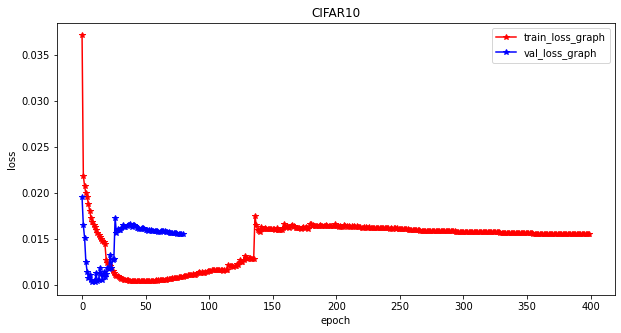

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_loss_graph,'r-*')
plt.plot(val_loss_graph, 'b-*')
plt.legend(['train_loss_graph','val_loss_graph'])
plt.title("CIFAR10")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()



In [ ]:
#모델 세이브

PATH1 = './model/Gs_blur_weak_DAE_model.pth'
PATH2 = './model/Gs_blur_moderate_DAE_model.pth'
PATH3 = './model/Gs_blur_strong_DAE_model.pth'

torch.save(mode1.state_dict(), PATH1)
torch.save(mode2.state_dict(), PATH2)
torch.save(mode3.state_dict(), PATH3)

In [ ]:
len(tr_loader)

1250

In [ ]:
print(images.size(0))

16


In [ ]:
#Batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()




NameError: ignored

In [ ]:
#Batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

#Sample outputs
images = images.to(device)
print('입력 이미지 크기',images.shape)

output = model(images)
print('출력 이미지 크기',output.shape)

images_np = images.cpu().numpy() #입력값은 그래디언 계산이 안 되었으므로(model 안 거침) detach가 필요 없다.
output=output.to(device)
output_np = output.detach().cpu().numpy()

#Original Image(5):
for idx in np.arange(5):
    
    image, label = dataier.next()
    image = image.to(device)
    output = model()

    val_ssim_scikit =  ssim((images_np[idx], output_np[idx], data_range = 1.0,multichannel = True)           

    PSNR_custom = Get_psnr(images[idx], output[idx], max_val = 1.0)
    PSNR_scikit = psnr(images_np[idx], output_np[idx], data_range = 1.0)
#    SSIM = pytorch_ssim(images[idx],output[idx]).data
#    SSIM = ssim(images[idx], output[idx], data_range = 1.0, multichannel =True)
    print(f'Class {classes[labels[idx]]} Scikit_PSNR {PSNR_scikit} / Custom_PSNR {PSNR_custom}')
#   print(SSIM)
    print("SSIM : {.3f}", val_ssim_scikit)
    ax = plt.subplot(2, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title(classes[labels[idx]])

    ax = plt.subplot(2, 5, idx+1+5, xticks=[], yticks=[])
    imshow(output[idx].detach().cpu().numpy())
    ax.set_title(classes[labels[idx]])
plt.show() 